# Predicting future fire sizes in CA

Based on data about precipitation, temperatures and previous fire sizes I want to predict intensity of fires in CA in the future. While doing that, I also want to explore which areas of CA are getting dryer and hotter the most

In [440]:
import pandas as pd
import numpy as np
import sqlite3
import os
from datetime import date, timedelta
import datetime
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV,RandomizedSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn import metrics
from sklearn.pipeline import Pipeline

# preprocessing, feature and model selection
from sklearn.preprocessing import PolynomialFeatures,StandardScaler,MinMaxScaler,PowerTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_classif,RFE, RFECV
from sklearn.pipeline import make_pipeline
import sklearn.pipeline as pipeline
from sklearn.model_selection import GridSearchCV,train_test_split,TimeSeriesSplit

#  models and metrics
import sklearn.linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from xgboost.sklearn import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
# reading data

percipitation = pd.read_csv(r"4-pcp.csv",skiprows=3)
temperatures = pd.read_csv(r"GlobalLandTemperaturesByCity.csv")
emissions = pd.read_csv(r"emissions.csv")
concentrations = pd.read_csv(r"atmospheric-concentration-of-carbon-dioxide-5.csv")
cities = pd.read_csv("uscities.csv")

In [3]:
temperatures.Latitude = [float(x[:-1]) for x in temperatures.Latitude]

In [4]:
con = sqlite3.connect("FPA_FOD_20170508.sqlite")
fires = pd.read_sql_query("SELECT STATE, FIRE_SIZE, LATITUDE, LONGITUDE, FIRE_YEAR FROM Fires WHERE STATE='CA'",con)

In [5]:
fires

,STATE,FIRE_SIZE,LATITUDE,LONGITUDE,FIRE_YEAR
0,CA,0.10,40.036944,-121.005833,2005
1,CA,0.25,38.933056,-120.404444,2004
2,CA,0.10,38.984167,-120.735556,2004
3,CA,0.10,38.559167,-119.913333,2004
4,CA,0.10,38.559167,-119.933056,2004
...,...,...,...,...,...
189545,CA,0.01,40.481637,-122.389375,2015
189546,CA,0.20,37.617619,-120.938570,2015
189547,CA,0.10,37.617619,-120.938570,2015
189548,CA,2.00,37.672235,-120.898356,2015


In [6]:
fires_yearly = fires.groupby("FIRE_YEAR").count()["FIRE_SIZE"]

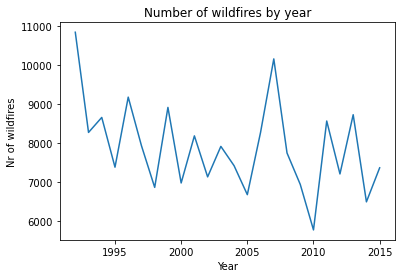

In [7]:
plt.plot(fires_yearly.index,fires_yearly.values)
plt.title("Number of wildfires by year")
plt.xlabel("Year")
plt.ylabel("Nr of wildfires")
plt.show()

In [8]:
yearly_acres_burned = fires.groupby("FIRE_YEAR").sum()["FIRE_SIZE"]

In [9]:
yearly_acres_burned

FIRE_YEAR
1992     296439.800
1993     321495.300
1994     407944.700
1995     216068.700
1996     707110.500
1997     324566.300
1998     160013.100
1999     804123.400
2000     252676.000
2001     350176.700
2002     514942.700
2003    1031965.050
2004     301095.970
2005     258714.870
2006     812711.940
2007    1045291.620
2008    1430153.600
2009     455350.040
2010     120947.040
2011     192286.920
2012     764766.640
2013     581410.292
2014     546878.780
2015     848728.610
Name: FIRE_SIZE, dtype: float64

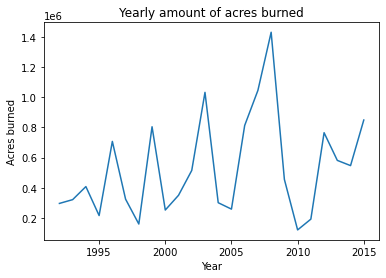

In [10]:
plt.plot(yearly_acres_burned.index,yearly_acres_burned.values)
plt.title("Yearly amount of acres burned")
plt.xlabel("Year")
plt.ylabel("Acres burned")
plt.show()

Let's decompose timeseries and see how the trend shapes up

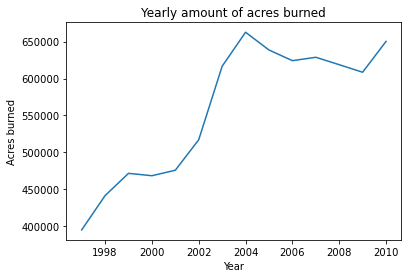

In [119]:
yearly_decomposed = seasonal_decompose(yearly_acres_burned,model="additive",period=10).trend

plt.plot(yearly_decomposed.index,yearly_decomposed.values)
plt.title("Yearly amount of acres burned")
plt.xlabel("Year")
plt.ylabel("Acres burned")
plt.show()

In [11]:
mean_fire_size = fires.groupby("FIRE_YEAR").mean()["FIRE_SIZE"]
mean_fire_size

FIRE_YEAR
1992     27.364516
1993     38.874885
1994     47.139438
1995     29.273635
1996     77.086068
1997     40.928916
1998     23.311932
1999     90.249540
2000     36.215565
2001     42.798423
2002     72.191602
2003    130.413882
2004     40.589912
2005     38.741370
2006     98.260421
2007    102.974251
2008    184.678926
2009     65.612398
2010     20.939584
2011     22.458178
2012    106.099700
2013     66.652561
2014     84.212932
2015    115.238100
Name: FIRE_SIZE, dtype: float64

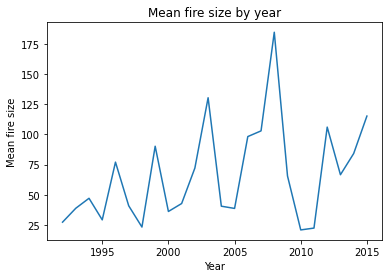

In [12]:
plt.plot(mean_fire_size.index,mean_fire_size.values)
plt.title("Mean fire size by year")
plt.xlabel("Year")
plt.ylabel("Mean fire size")
plt.show()

Interestingly, there seems to be some kind of seasonality in fire sizes, as intensive fire seasons seem to come every 3/5 years, further apart with time, but more intense. Not much trend in amount of fires is present

In [13]:
percipitation["year"] = [int(str(x)[0:4]) for x in percipitation["Date"]]
percipitation["month"] = [int(str(x)[4:]) for x in percipitation["Date"]]

In [14]:
no_cal = ["Alameda",
"Alpine",
"Amador",
"Butte",
"Calaveras",
"Colusa",
"Contra Costa",
"Del Norte",
"El Dorado",
"Fresno",
"Glenn",
"Humboldt",
"Inyo",
"Kings",
"Lake",
"Lassen",
"Madera",
"Marin",
"Mariposa",
"Mendocino",
"Merced",
"Modoc",
"Mono",
"Monterey",
"Napa",
"Nevada",
"Placer",
"Plumas",
"Sacramento",
"San Benito",
"San Francisco",
"San Joaquin",
"San Mateo",
"Santa Clara",
"Santa Cruz",
"Shasta",
"Sierra",
"Siskiyou",
"Solano",
"Sonoma",
"Stanislaus",
"Sutter",
"Tehama",
"Trinity",
"Tulare",
"Tuolumne",
"Yolo",
"Yuba"]

In [15]:
percipitation = percipitation[percipitation.year > 1950]
percipitation.Location = [x[:-7] for x in percipitation.Location]

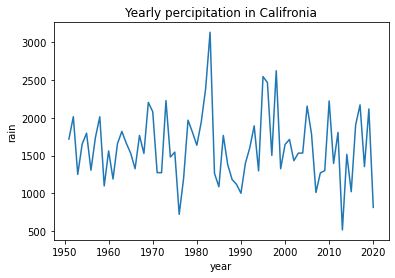

In [16]:
# plotting mean yearly percipitation 
plt.plot(percipitation.groupby("year").sum().Value)
plt.ylabel("rain")
plt.xlabel("year")
plt.title("Yearly percipitation in Califronia")
plt.show()

Percipitation is not really showing any trends, let's see if they appear when divided into months

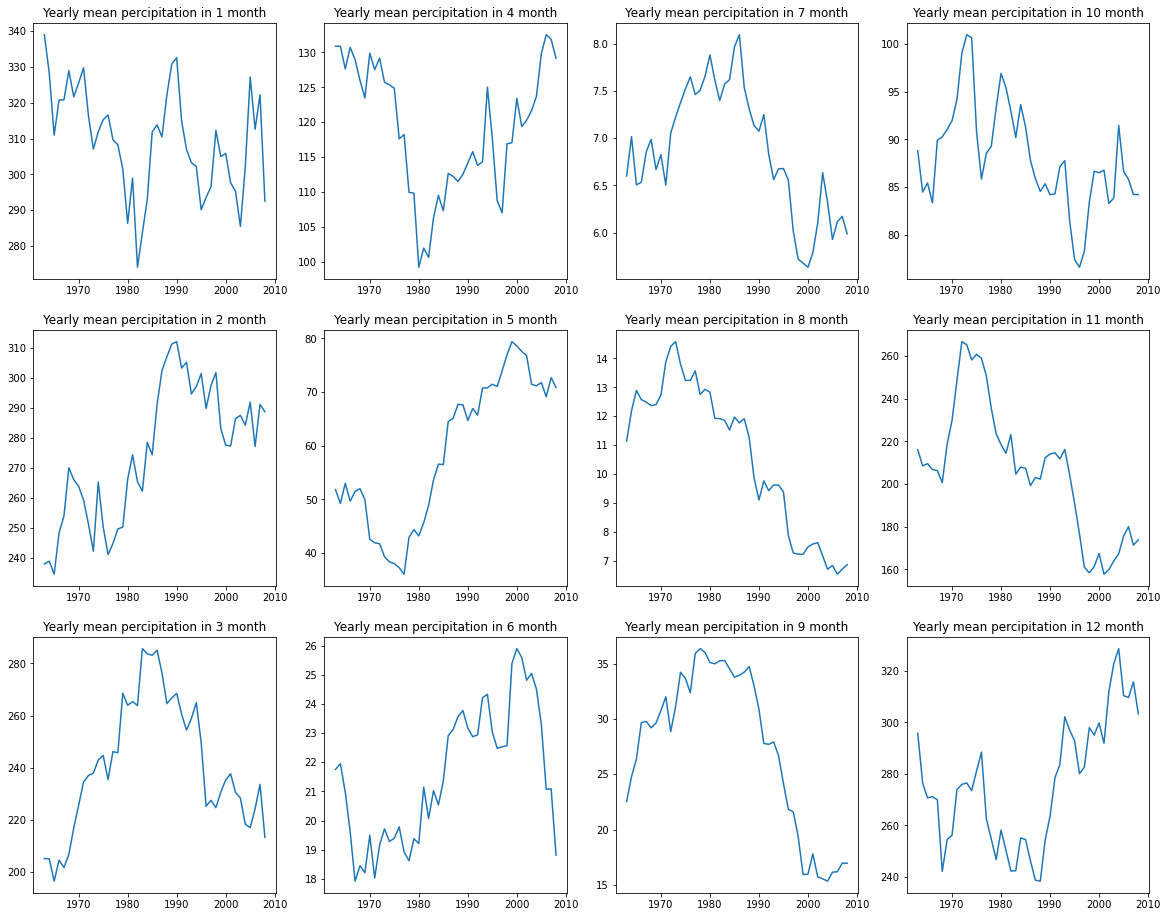

In [17]:
# plotting monthly mean percipitation over the years
fig, ax = plt.subplots(3,4,figsize=(20,16))
months = np.array([1,2,3,4,5,6,7,8,9,10,11,12]).reshape(3,4)

for i in range(3):
    for j in range(4):
        # decomposing timeseries to see trend. Large period to see long distance trends
        decomposition = seasonal_decompose((percipitation[percipitation.month == (3*j + i+1)].groupby("year").sum().Value),
                                           model="additive",period=25).trend
        ax[i][j].plot(decomposition)
        ax[i][j].set_title(f"Yearly mean percipitation in {(3*j + i+1)} month")
    

The rain seems to be in getting heavier in spring and winter, typical rainy seasons in CA, and getting even weaker in summer and autumn months. Big change in november seems especially interesting

In [18]:
temperatures["year"] = [int(x[:4]) for x in temperatures.dt]
temperatures["month"] = [int(x[5:7]) for x in temperatures.dt]

In [19]:
temperatures_cities = temperatures[temperatures.Country == "United States"].City.unique()

In [20]:
cities_ca = cities[cities.state_id == "CA"]

In [21]:
ca_cities = [x for x in temperatures_cities if x in list(cities_ca.city)]

In [22]:
ca_cities

['Anaheim',
 'Antioch',
 'Bakersfield',
 'Beaumont',
 'Berkeley',
 'Bridgeport',
 'Burbank',
 'Chula Vista',
 'Columbia',
 'Concord',
 'Corona',
 'Costa Mesa',
 'Downey',
 'Durham',
 'East Los Angeles',
 'El Monte',
 'Escondido',
 'Fairfield',
 'Fontana',
 'Fremont',
 'Fresno',
 'Fullerton',
 'Garden Grove',
 'Glendale',
 'Hayward',
 'Huntington Beach',
 'Independence',
 'Inglewood',
 'Irvine',
 'Jackson',
 'Lafayette',
 'Lakewood',
 'Lancaster',
 'Lincoln',
 'Long Beach',
 'Los Angeles',
 'Madison',
 'Manchester',
 'Mesa',
 'Modesto',
 'Moreno Valley',
 'Newark',
 'Norwalk',
 'Oakland',
 'Oceanside',
 'Ontario',
 'Orange',
 'Oxnard',
 'Palmdale',
 'Paradise',
 'Pasadena',
 'Pomona',
 'Rancho Cucamonga',
 'Rialto',
 'Richmond',
 'Riverside',
 'Roseville',
 'Sacramento',
 'Salinas',
 'San Bernardino',
 'San Diego',
 'San Francisco',
 'San Jose',
 'Santa Ana',
 'Santa Clara',
 'Santa Clarita',
 'Santa Rosa',
 'Simi Valley',
 'Spring Valley',
 'Stockton',
 'Sunnyvale',
 'Thornton',
 'Thou

In [23]:
ca_temperature = temperatures[temperatures.City.isin(ca_cities)]

In [24]:
ca_temperature = ca_temperature[(ca_temperature.year > 1920)&(ca_temperature.year < 2013)]

In [25]:
ca_temperature

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,year,month
275116,1921-01-01,12.147,0.474,Anaheim,United States,32.95,117.77W,1921,1
275117,1921-02-01,13.058,0.451,Anaheim,United States,32.95,117.77W,1921,2
275118,1921-03-01,13.836,0.467,Anaheim,United States,32.95,117.77W,1921,3
275119,1921-04-01,12.793,0.531,Anaheim,United States,32.95,117.77W,1921,4
275120,1921-05-01,13.146,0.426,Anaheim,United States,32.95,117.77W,1921,5
...,...,...,...,...,...,...,...,...,...
8224028,2012-08-01,21.798,0.279,Windsor,United States,42.59,82.91W,2012,8
8224029,2012-09-01,17.172,0.238,Windsor,United States,42.59,82.91W,2012,9
8224030,2012-10-01,10.758,0.296,Windsor,United States,42.59,82.91W,2012,10
8224031,2012-11-01,3.800,0.222,Windsor,United States,42.59,82.91W,2012,11


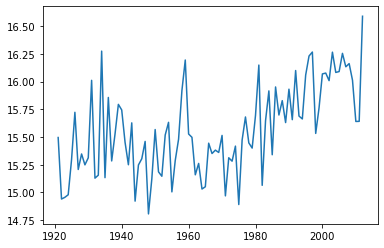

In [26]:
plt.plot(ca_temperature.groupby("year").mean().AverageTemperature)

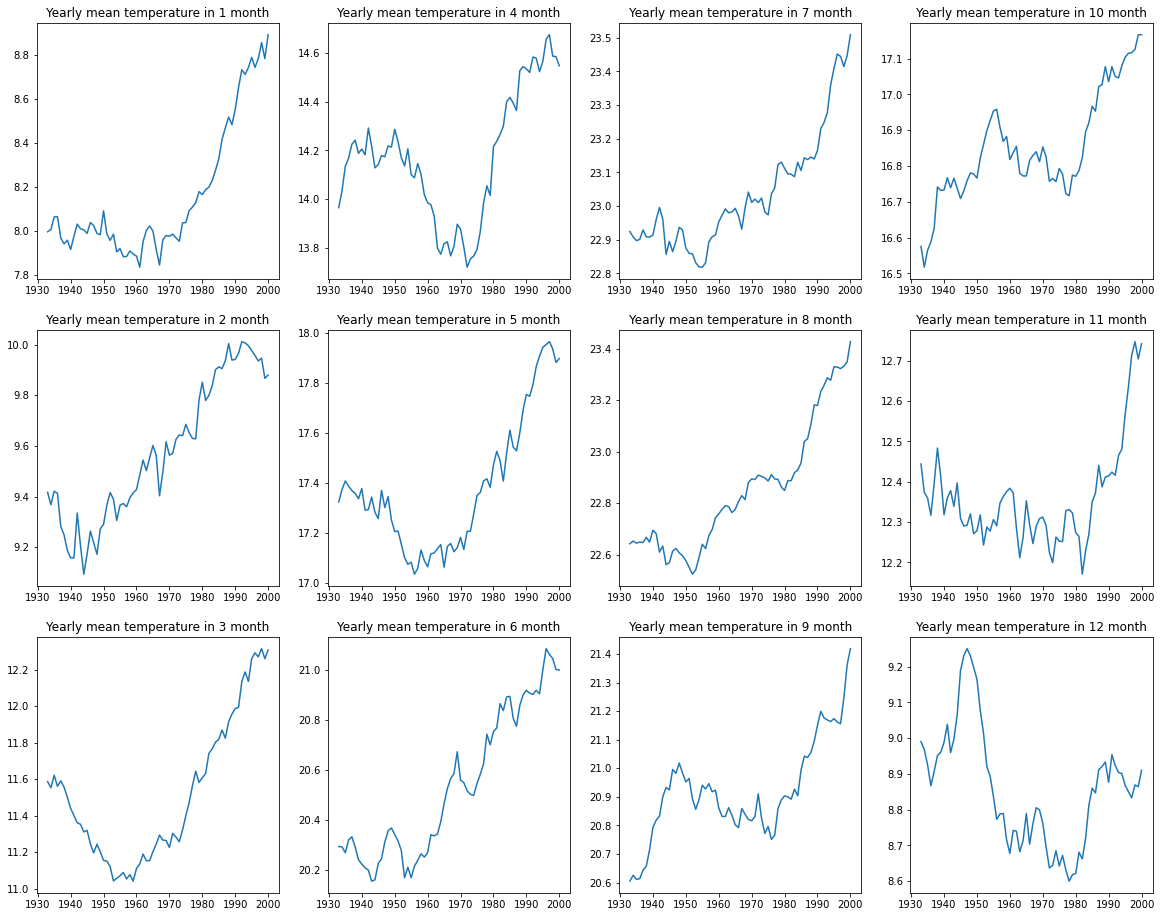

In [27]:
# plotting monthly mean temperature over the years
fig, ax = plt.subplots(3,4,figsize=(20,16))
months = np.array([1,2,3,4,5,6,7,8,9,10,11,12]).reshape(3,4)

for i in range(3):
    for j in range(4):
        # decomposing timeseries to see trend. Large period to see long distance trends
        decomposition = seasonal_decompose((ca_temperature[ca_temperature.month == (3*j + i+1)].groupby("year").mean().AverageTemperature),
                                           model="additive",period=25).trend
        ax[i][j].plot(decomposition)
        ax[i][j].set_title(f"Yearly mean temperature in {(3*j + i+1)} month")

Temperatures are rising intensively across months, with slight exception of october. Let's see percipitation and temperature alongside

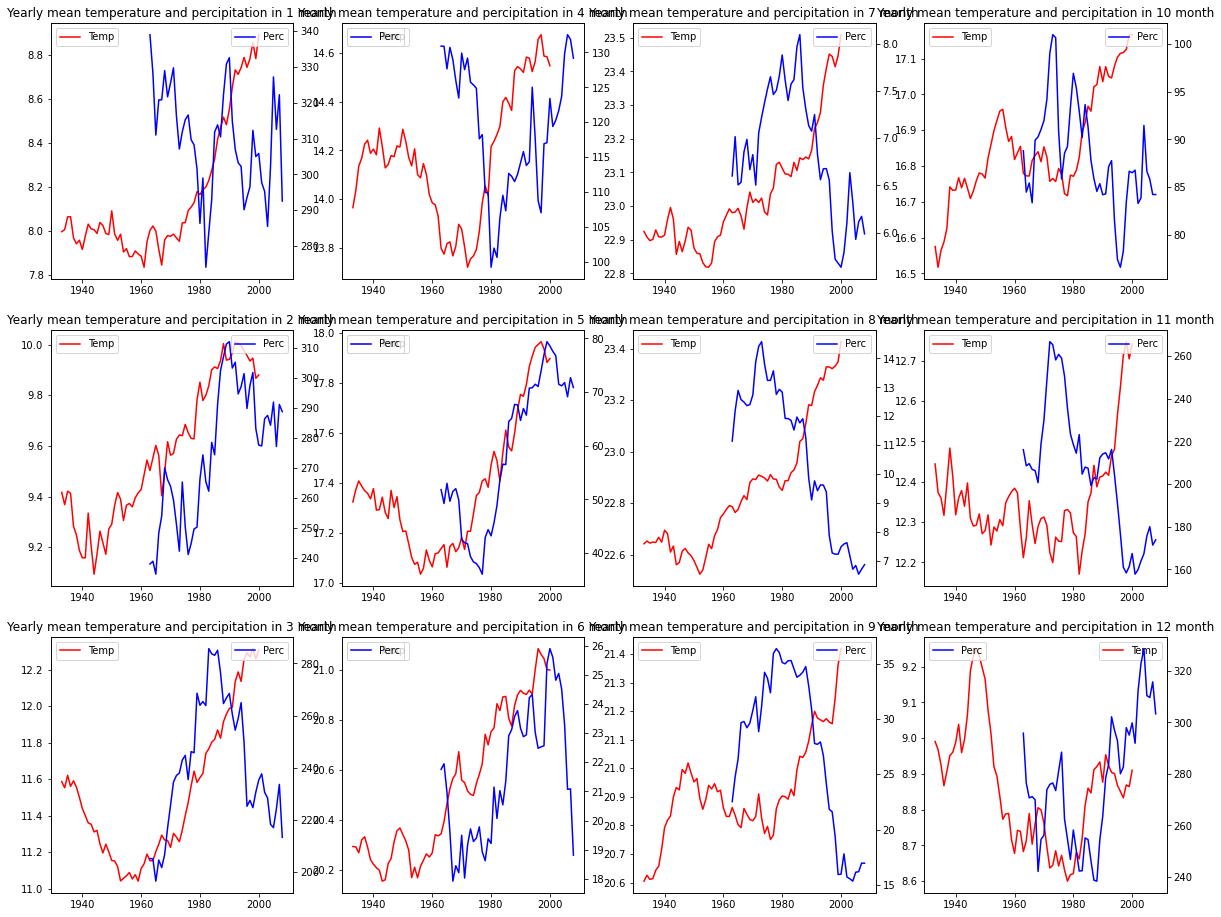

In [28]:
# plotting monthly mean temperature over the years
fig, ax = plt.subplots(3,4,figsize=(20,16))
months = np.array([1,2,3,4,5,6,7,8,9,10,11,12]).reshape(3,4)

for i in range(3):
    for j in range(4):
        # decomposing timeseries to see trend. Large period to see long distance trends
        decomposition_t = seasonal_decompose((ca_temperature[ca_temperature.month == (3*j + i+1)].groupby("year").mean().AverageTemperature),
                                           model="additive",period=25).trend
        decomposition_p = seasonal_decompose((percipitation[percipitation.month == (3*j + i+1)].groupby("year").sum().Value),
                                           model="additive",period=25).trend
        ax[i][j].plot(decomposition_t,color="r",label="Temp")
        ax[i][j].legend()
        ax_b = ax[i][j].twinx()
        ax_b.plot(decomposition_p,color="b",label="Perc")
        ax_b.legend()
        ax[i][j].set_title(f"Yearly mean temperature and percipitation in {(3*j + i+1)} month")

There seems to be a positive correlation in spring months (higher temperatures) more rain and negative in the summer (higher temperatures, less rain)

Before proceeding to preparing data for prediction, let's take a look at fire sizes compared to mean temperatures

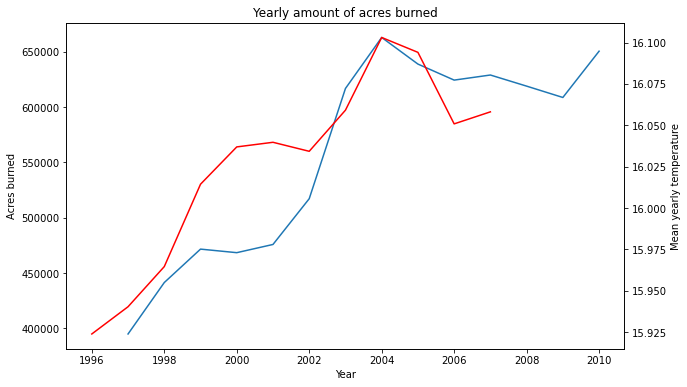

In [41]:
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(yearly_decomposed.index,yearly_decomposed.values)
ax.set_title("Yearly amount of acres burned")
ax.set_xlabel("Year")
ax.set_ylabel("Acres burned")

temp_decomposed = seasonal_decompose(ca_temperature[ca_temperature.year > 1990].groupby("year").mean().AverageTemperature,
                                    period=10,model="additive").trend
ax1 = ax.twinx()
ax1.plot(temp_decomposed.index,temp_decomposed.values,color="r")
ax1.set_ylabel("Mean yearly temperature")

plt.show()


There is a groving simultainously in both measurements

### Northen CA vs Southern CA

Let's examine if these trends differ betweene two parts of California in the most popular division. If yes, than it could be be beneficial to make two different predictions for these parts

In [30]:
so_cal_temp = ca_temperature[ca_temperature.Latitude <= 37]
so_cal_per = percipitation[~percipitation.Location.isin(no_cal)]
so_cal_fires = fires[fires.LATITUDE <= 37]

no_cal_temp = ca_temperature[ca_temperature.Latitude > 37]
no_cal_per = percipitation[percipitation.Location.isin(no_cal)]
no_cal_fires = fires[fires.LATITUDE > 37]

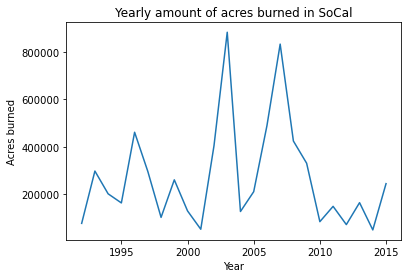

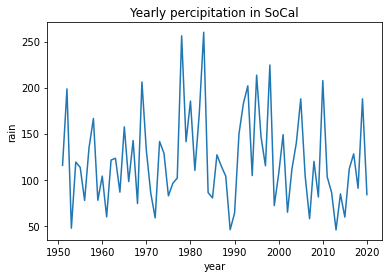

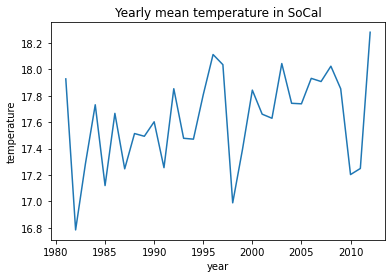

In [31]:
# plotting values for Southern california

# fires
so_cal_burned_yearly = so_cal_fires.groupby("FIRE_YEAR").sum()["FIRE_SIZE"]
plt.plot(so_cal_burned_yearly.index,so_cal_burned_yearly.values)
plt.title("Yearly amount of acres burned in SoCal")
plt.xlabel("Year")
plt.ylabel("Acres burned")
plt.show()
# rain
plt.plot(so_cal_per.groupby("year").sum().Value)
plt.ylabel("rain")
plt.xlabel("year")
plt.title("Yearly percipitation in SoCal")
plt.show()
# temperature
plt.plot(so_cal_temp[so_cal_temp.year>1980].groupby("year").mean().AverageTemperature)
plt.title("Yearly mean temperature in SoCal")
plt.ylabel("temperature")
plt.xlabel("year")
plt.show()

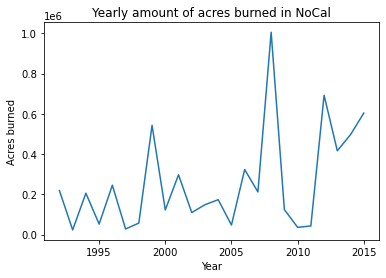

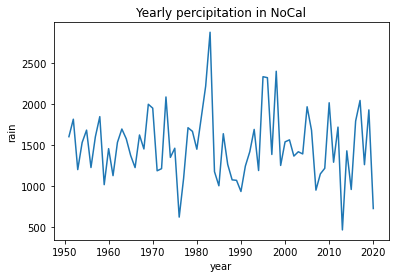

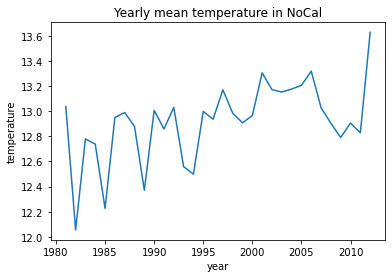

In [32]:
# plotting values for nothern california

# fires
no_cal_burned_yearly = no_cal_fires.groupby("FIRE_YEAR").sum()["FIRE_SIZE"]
plt.plot(no_cal_burned_yearly.index,no_cal_burned_yearly.values)
plt.title("Yearly amount of acres burned in NoCal")
plt.xlabel("Year")
plt.ylabel("Acres burned")
plt.show()
# rain
plt.plot(no_cal_per.groupby("year").sum().Value)
plt.ylabel("rain")
plt.xlabel("year")
plt.title("Yearly percipitation in NoCal")
plt.show()
# temperature
plt.plot(no_cal_temp[no_cal_temp.year>1980].groupby("year").mean().AverageTemperature)
plt.title("Yearly mean temperature in NoCal")
plt.ylabel("temperature")
plt.xlabel("year")
plt.show()

Trends in temperature and percipitation are very similar. When it comes to fires, sometimes intensive fire seasons take place in both parts, sometimes only in one

### Next steps

1. Testing simple linear regression model on historical data to see if prediction is possible and using it as a threshold.
2. Predicting future temperature rise using co2 concentration levels
3. Using ARIMA to predict future percipitation levels
4. Combining data and predicting future fire sizes with regression based on future temperatures and percipitation levels

In [120]:
# preparing data for prediction using Lasso Linear Regression

pred_temp = ca_temperature[ca_temperature.year > 1990].groupby("year").mean().AverageTemperature.reset_index()
pred_per = percipitation[percipitation.year>1990].groupby("year").sum().Value.reset_index()
pred_fire = mean_fire_size.reset_index().rename({"FIRE_YEAR":"year"},axis=1)

In [121]:
to_predict = pred_fire.merge(pred_temp.merge(pred_per,on="year"),on="year").rename({"FIRE_SIZE":"mean_size",
                                                                                    "AverageTemperature":"temp",
                                                                                   "Value":"perc"},axis=1)

In [122]:
pred_fire

,year,FIRE_SIZE
0,1992,27.364516
1,1993,38.874885
2,1994,47.139438
3,1995,29.273635
4,1996,77.086068
5,1997,40.928916
6,1998,23.311932
7,1999,90.249540
8,2000,36.215565
9,2001,42.798423


In [123]:
to_predict["size_last_year"] = [to_predict["mean_size"][x-1] for x in range((len(to_predict["mean_size"])+1)) if x!=0]

In [124]:
to_predict["size_last_year"][0] = 0
to_predict["size_last_year"][1:] = last_year[:-4]

<ipython-input-124-a6d9ec30d6d2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_predict["size_last_year"][0] = 0
<ipython-input-124-a6d9ec30d6d2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_predict["size_last_year"][1:] = last_year[:-4]


In [89]:
last_year = [pred_fire["FIRE_SIZE"][x] for x in range((len(pred_fire["FIRE_SIZE"])))]
len(to_predict["size_last_year"][1:])

20

In [93]:
to_predict

,year,mean_size,temp,perc,size_last_year
0,1992,27.364516,16.099645,1601.96,0.000000
1,1993,38.874885,15.689301,1892.61,27.364516
2,1994,47.139438,15.663322,1295.79,38.874885
3,1995,29.273635,16.058798,2545.04,47.139438
4,1996,77.086068,16.230307,2466.21,29.273635
5,1997,40.928916,16.266365,1501.52,77.086068
6,1998,23.311932,15.532613,2622.23,40.928916
7,1999,90.249540,15.763418,1325.01,23.311932
8,2000,36.215565,16.069117,1646.00,90.249540
9,2001,42.798423,16.076751,1712.73,36.215565


In [125]:
train = to_predict[1:16]
test = to_predict[16:]

In [126]:
test

,year,mean_size,temp,perc,size_last_year
16,2008,184.678926,16.162228,1270.23,102.974251
17,2009,65.612398,16.012203,1299.35,184.678926
18,2010,20.939584,15.640461,2222.42,65.612398
19,2011,22.458178,15.641437,1395.14,20.939584
20,2012,106.099700,16.589190,1804.88,22.458178


In [127]:
X_train,y_train = train[["temp","size_last_year"]], train["mean_size"]
X_test,y_test = test[["temp","size_last_year"]],test["mean_size"]

In [129]:
reg = make_pipeline(RandomForestRegressor())
reg.fit(X_train,y_train)
print(reg.score(X_test,y_test))
preds = reg.predict(X_test)
np.sqrt(mean_squared_error(y_test,preds))

0.27859006161408206


51.86662040282182

In [105]:
preds,pred_fire

(array([88.53696416, 65.24957393, 38.89170023, 69.8012077 , 76.32934624]),
     year   FIRE_SIZE
 0   1992   27.364516
 1   1993   38.874885
 2   1994   47.139438
 3   1995   29.273635
 4   1996   77.086068
 5   1997   40.928916
 6   1998   23.311932
 7   1999   90.249540
 8   2000   36.215565
 9   2001   42.798423
 10  2002   72.191602
 11  2003  130.413882
 12  2004   40.589912
 13  2005   38.741370
 14  2006   98.260421
 15  2007  102.974251
 16  2008  184.678926
 17  2009   65.612398
 18  2010   20.939584
 19  2011   22.458178
 20  2012  106.099700
 21  2013   66.652561
 22  2014   84.212932
 23  2015  115.238100)

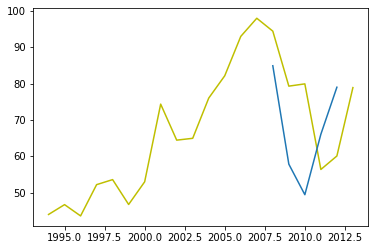

In [142]:
dec = seasonal_decompose(mean_fire_size,model="additive",period=5).trend
plt.plot(dec,color="y")
plt.plot([2008,2009,2010,2011,2012],preds)

Metrics for the model are far from satisfactory, but it seems that the trend is somehow preserved in predictions. Let's try to predict temperatures and percipitation, fine tune models and see what comes out of this.

First, let's predict temperatures in CA based on co2 concentration levels predicted with ARIMA. Model is simplified and does not reflect changing emission levels and other factors. For now it is only simple timeseries prediction

In [257]:
concentrations["Polutant:text"].unique()

array(['CO2 (ppm)', 'CH4 (ppb)', 'N2O (ppb)'], dtype=object)

In [258]:
co2_lvls = concentrations[concentrations["Polutant:text"] == "CO2 (ppm)"]

In [259]:
co2_lvls.rename({"Year:year":"year","Value:number":"concentration"},axis=1,inplace=True)

C:\Users\szklarnia\anaconda3\lib\site-packages\pandas\core\frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [260]:
co2_lvls.drop("Polutant:text",axis=1,inplace=True)

C:\Users\szklarnia\anaconda3\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [261]:
co2_lvls.index=co2_lvls.year
co2_lvls.drop("year",axis=1,inplace=True)

In [262]:
co2_lvls=pd.Series(co2_lvls.concentration,co2_lvls.index)

In [156]:
def find_best_order(orders,series):
    """
    Function evaluating ARIMA models. Function takes list of ARIMA orders and Series of data to fit models
    """
    
    # creating variables
    best_order = ()
    best_score = float("inf")
    is_naive = ""
    # creating splits object
    X = series
    splits = TimeSeriesSplit(n_splits=4)
    for order in orders:
        # not all models can be created with given parameters
        try:
            print(order)
            # creating variables to save errors for each split
            errors = []
            naive_errors = []
            # iterating over splits
            for train_index,test_index in splits.split(X):
                # creating train and test variables
                train = X.iloc[train_index]
                test = X.iloc[test_index]

                # creating variables for one forward testing
                history = [x for x in train]
                predicted = []
                naive = X.iloc[test_index-1]

                # one forward arima testing
                for t in test:
                    # creating and fitting model
                    model = ARIMA(history,order)
                    model_fit = model.fit()
                    # forecasting and appending variables
                    val = model_fit.forecast()[0]
                    predicted.append(val)
                    history.append(t)

                # calculating and appending errors for current split
                error = metrics.mean_squared_error(test,predicted)
                naive_err = metrics.mean_squared_error(test,naive)
                errors.append(error)
                naive_errors.append(naive_err)

            # calculating mean prediction error for tested order
            error_order = np.mean(errors)
            naive_error = np.mean(naive_errors)

            # checking if error is smaller than threshold (naive prediction error)
            if error_order < naive_error:
                is_naive = "No"
                # checking if error is smaller than current best model error
                if error_order < best_score:
                    # updating variables
                    best_order = order
                    best_score = error_order
            # passing orders which couldn't be constructed
        except:
            continue
    # prediction is worse than naive baseline
    if is_naive == "Yes":
        return "No prediction was better than naive"
    # prediction is better than naive baseline
    elif is_naive == "No":
        return best_order

In [165]:
orders = [(x,y,z) for x in range(0,4) for y in range(0,3) for z in range(0,3)]

best = find_best_order(orders,co2_lvls)

(0, 0, 0)


C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_

(0, 0, 1)


C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_

(0, 0, 2)
(0, 1, 0)


C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check ml

(0, 1, 1)


C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_

(0, 1, 2)


C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params availabl

(0, 2, 0)


C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_

(0, 2, 1)


C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_

(0, 2, 2)


C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_

(1, 0, 0)


C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:218: RuntimeWarning: divide by zero encountered in true_divide
  loglik

C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        Fut

(1, 0, 1)
(1, 0, 2)
(1, 1, 0)


C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:218: RuntimeWarning: divide by zero encountered in true_divide
  loglike, sigma2 = kalman_loglike.kalman_loglike_double(
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  war

(1, 1, 1)


C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_

C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_

C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_

C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_

C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_

C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_

(1, 1, 2)


C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_

C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_

C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_

(1, 2, 0)


C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_

(1, 2, 1)
(1, 2, 2)
(2, 0, 0)


C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:684: RuntimeWarning: divide by zero encountered in arctanh
  invarcoefs = 2*np.arct

(2, 0, 1)


C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        

(2, 0, 2)
(2, 1, 0)


C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_

(2, 1, 1)
(2, 1, 2)


C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_

(2, 2, 0)


C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_

(2, 2, 1)


C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_

C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_

C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_

C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_

C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_

C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_

(2, 2, 2)
(3, 0, 0)


C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check ml

(3, 0, 1)


C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        

C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        

(3, 0, 2)
(3, 1, 0)


C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_

(3, 1, 1)
(3, 1, 2)


C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_

(3, 2, 0)


C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_

(3, 2, 1)


C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params availabl

C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, 

C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, 

C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_

C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        Fut

C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_

C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_

C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_

(3, 2, 2)


C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        Fut

In [166]:
best

(1, 1, 0)

In [263]:
model = ARIMA(co2_lvls,best)
model_fitted = model.fit()

C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\szklarnia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when

In [264]:
predicted_values = pd.Series(model_fitted.forecast(32)[0],index=np.arange(2018,2050))

In [265]:
predicted_values

2018    409.764458
2019    411.789997
2020    413.692665
2021    415.500331
2022    417.234546
2023    418.911971
2024    420.545486
2025    422.145052
2026    423.718370
2027    425.271393
2028    426.808725
2029    428.333926
2030    429.849746
2031    431.358313
2032    432.861274
2033    434.359899
2034    435.855172
2035    437.347853
2036    438.838530
2037    440.327659
2038    441.815589
2039    443.302593
2040    444.788881
2041    446.274615
2042    447.759922
2043    449.244897
2044    450.729616
2045    452.214138
2046    453.698507
2047    455.182757
2048    456.666916
2049    458.151004
dtype: float64

In [266]:
co2_lvls

year
1750    278.00
1755    278.00
1760    278.00
1765    278.00
1770    278.60
         ...  
2014    397.45
2015    399.58
2016    402.87
2017    405.19
2018    407.58
Name: concentration, Length: 87, dtype: float64

In [267]:
co2_lvls.rename({0:"Concentration"},axis=1,inplace=True)

In [269]:
co2_lvls = co2_lvls.append(predicted_values)

In [271]:
co2_lvls = co2_lvls.reset_index()

In [277]:
co2_lvls.rename({"index":"year",0:"Concentration"},axis=1,inplace=True)

In [278]:
co2_lvls

,year,Concentration
0,1750,278.000000
1,1755,278.000000
2,1760,278.000000
3,1765,278.000000
4,1770,278.600000
...,...,...
114,2045,452.214138
115,2046,453.698507
116,2047,455.182757
117,2048,456.666916


In [279]:
ca_temp = ca_temperature.groupby("year").mean().AverageTemperature

In [280]:
ca_temp = ca_temp[ca_temp.index.isin(co2_lvls.year)]

In [281]:
ca_temp_adds = pd.Series(np.zeros(37),index = np.arange(2013,2050))

In [282]:
ca_temp = pd.DataFrame(ca_temp.append(ca_temp_adds))

In [284]:
ca_temp = ca_temp.reset_index()

In [286]:
ca_temp.rename({"index":"year"},axis=1,inplace=True)

In [255]:
co2_lvls = co2_lvls[co2_lvls.index.isin(ca_temp.index)]

In [289]:
co2_temperature = co2_lvls.merge(ca_temp,on="year")

In [294]:
co2_temperature[0]

0     15.295901
1     15.312695
2     15.133723
3     15.744121
4     15.248294
        ...    
79     0.000000
80     0.000000
81     0.000000
82     0.000000
83     0.000000
Name: 0, Length: 84, dtype: float64

In [295]:
co2_temperature["previous"] = 0
co2_temperature["previous"][1:-1] = [x for x in co2_temperature[0][:-2]]

<ipython-input-295-7efab477b092>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  co2_temperature["previous"][1:-1] = [x for x in co2_temperature[0][:-2]]


In [305]:
co2_temperature.index=co2_temperature.year

In [333]:
co2_temperature.rename({0:"temp"},axis=1,inplace=True)

In [297]:
def one_forward_regression(data,target,model,X):
    """ Function takes training data, model and X values for which to make a prediction. 
        Function fits model on training data and predicts target value for X"""
    features = data.drop(target,axis=1)
    target = data[target]
    
    model.fit(features,target)
    result = model.predict(X)

    return result

In [375]:
history = co2_temperature.loc[:2012].drop_duplicates("year")
future = co2_temperature.loc[2013:].drop_duplicates("year")

model = make_pipeline(StandardScaler(),Lasso(alpha=0.0001))

for i in range(2013,2050):
    next_year = future[future.index==i]
    prediction = one_forward_regression(history,"temp",model,next_year.drop("temp",axis=1))
    next_year["temp"] = prediction
    next_year["previous"] = history["temp"][i-1]
    history = history.append(next_year)

    future["previous"].loc[i+1] = history.loc[i]["temp"]

In [376]:
history.loc[2010:]

,year,Concentration,temp,previous
year,,,,
2010,2010,388.710000,15.640461,16.012203
2011,2011,390.570000,15.641437,15.640461
2012,2012,392.640000,16.589190,15.641437
2013,2013,395.490000,16.265307,16.589190
2014,2014,397.450000,16.289738,16.265307
2015,2015,399.580000,16.316004,16.289738
2016,2016,402.870000,16.358476,16.316004
2017,2017,405.190000,16.387360,16.358476
2018,2018,407.580000,16.417240,16.387360


Predicting percipitation, ARIMA

In [380]:
perc_yearly = percipitation.groupby("year").sum().Value

In [389]:
orders = [(x,y,z) for x in range(0,4) for y in range(0,3) for z in range(1,3)]

best = find_best_order(orders,perc_yearly[:-1])

(0, 0, 1)
(0, 0, 2)
(0, 1, 1)
(0, 1, 2)
(0, 2, 1)
(0, 2, 2)
(1, 0, 1)
(1, 0, 2)
(1, 1, 1)
(1, 1, 2)
(1, 2, 1)
(1, 2, 2)
(2, 0, 1)
(2, 0, 2)
(2, 1, 1)
(2, 1, 2)
(2, 2, 1)
(2, 2, 2)
(3, 0, 1)
(3, 0, 2)
(3, 1, 1)
(3, 1, 2)
(3, 2, 1)
(3, 2, 2)


In [390]:
model = ARIMA(perc_yearly[:-1],best)
model_fitted = model.fit()

In [391]:
predicted_perc = pd.Series(model_fitted.forecast(30)[0],index=np.arange(2020,2050))

In [392]:
perc_yearly.append(predicted_perc)

1951    1718.06000
1952    2013.47000
1953    1249.66000
1954    1651.01000
1955    1795.64000
           ...    
2045    1628.55068
2046    1628.55068
2047    1628.55068
2048    1628.55068
2049    1628.55068
Length: 100, dtype: float64

In [393]:
predicted_perc

2020    1664.580993
2021    1633.683951
2022    1629.282022
2023    1628.654875
2024    1628.565525
2025    1628.552795
2026    1628.550981
2027    1628.550723
2028    1628.550686
2029    1628.550681
2030    1628.550680
2031    1628.550680
2032    1628.550680
2033    1628.550680
2034    1628.550680
2035    1628.550680
2036    1628.550680
2037    1628.550680
2038    1628.550680
2039    1628.550680
2040    1628.550680
2041    1628.550680
2042    1628.550680
2043    1628.550680
2044    1628.550680
2045    1628.550680
2046    1628.550680
2047    1628.550680
2048    1628.550680
2049    1628.550680
dtype: float64

In [399]:
mean_fire_size

FIRE_YEAR
1992     27.364516
1993     38.874885
1994     47.139438
1995     29.273635
1996     77.086068
1997     40.928916
1998     23.311932
1999     90.249540
2000     36.215565
2001     42.798423
2002     72.191602
2003    130.413882
2004     40.589912
2005     38.741370
2006     98.260421
2007    102.974251
2008    184.678926
2009     65.612398
2010     20.939584
2011     22.458178
2012    106.099700
2013     66.652561
2014     84.212932
2015    115.238100
Name: FIRE_SIZE, dtype: float64

In [418]:
fire_to_pred = mean_fire_size
temp_to_pred = history.temp.reset_index()
perc_to_pred = perc_yearly.append(predicted_perc).reset_index()

In [419]:
fire_to_pred = fire_to_pred.append(pd.Series(np.zeros(34),index=np.arange(2016,2050))).reset_index()

In [420]:
fire_to_pred.rename({"index":"year",0:"size"},axis=1,inplace=True)

In [428]:
perc_to_pred.rename({"index":"year",0:"perc"},axis=1,inplace=True)

In [433]:
data_for_prediction = perc_to_pred.merge(fire_to_pred.merge(temp_to_pred,on="year"),on="year")

In [435]:
data_for_prediction["prev"]= 0

In [437]:
data_for_prediction["prev"][1:] = data_for_prediction["size"][:-1]

In [439]:
data_for_prediction

,year,perc,size,temp,prev
0,1992,1601.960000,27.364516,16.099645,0.000000
1,1993,1892.610000,38.874885,15.689301,27.364516
2,1994,1295.790000,47.139438,15.663322,38.874885
3,1995,2545.040000,29.273635,16.058798,47.139438
4,1996,2466.210000,77.086068,16.230307,29.273635
5,1997,1501.520000,40.928916,16.266365,77.086068
6,1998,2622.230000,23.311932,15.532613,40.928916
7,1999,1325.010000,90.249540,15.763418,23.311932
8,2000,1646.000000,36.215565,16.069117,90.249540
9,2001,1712.730000,42.798423,16.076751,36.215565


In [441]:
def fine_tuning_timeseries(data,target,models,param_grids,split):
    X = data.drop(target,axis=1)
    y = data[target]
    
    X_train, X_test = timeseries_split(X,split)
    y_train, y_test = timeseries_split(y,split)
    
    tscv = TimeSeriesSplit(n_splits=4)
    
    best_model = ""
    best_score = -float("inf")
    
    for i in range(len(models)):
        grid = GridSearchCV(models[i],
                       param_grid=param_grids[i],
                       cv = tscv,
                       scoring = 'neg_mean_squared_error',
                       verbose=3,
                       n_jobs = 3)
        grid.fit(X_train,y_train)
        pred = grid.predict(X_test)
        score = grid.score(X_test,y_test)
        if score>best_score:
            best_model = grid.best_params_
            best_score = score
        print(score)
    
    
    print(f"Best model is {best_model}, with score: {best_score}")

In [452]:
def timeseries_split(data,x):
    try:
        train, test = data[:x], data[x:]
    except:
        train, test = data[:x], data[x:]
    return train, test

In [443]:
models = (Pipeline([("scaler",StandardScaler()),("lasso",Lasso())]),
         Pipeline([("scaler",StandardScaler()),("tree",DecisionTreeRegressor())]),
         Pipeline([("scaler",StandardScaler()),("forest",RandomForestRegressor())]))
grids = ({"lasso__alpha":[0.0001,0.001,0.01,0.1,1,10,100]},
        {"tree__max_depth":[None,10,50,100],"tree__min_samples_split":[2,4,6,8],"tree__min_samples_leaf":[1,2,3,4]},
        {"forest__n_estimators":[100,200],"forest__criterion":["mse","mae"],"forest__max_depth":[None,5,10,20],
            "forest__min_samples_split":[2,4,6,8],"forest__min_samples_leaf":[1,2,3,4]})

In [464]:
fine_tuning_timeseries(data_for_prediction[1:24],"size",models,grids,20)

Fitting 4 folds for each of 7 candidates, totalling 28 fits
-944.4915153601673
Fitting 4 folds for each of 64 candidates, totalling 256 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:    0.2s
[Parallel(n_jobs=3)]: Done 256 out of 256 | elapsed:    0.4s finished


-695.0964851568896
Fitting 4 folds for each of 256 candidates, totalling 1024 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  46 tasks      | elapsed:    2.1s
[Parallel(n_jobs=3)]: Done 238 tasks      | elapsed:   10.9s
[Parallel(n_jobs=3)]: Done 558 tasks      | elapsed:   27.0s
[Parallel(n_jobs=3)]: Done 1006 tasks      | elapsed:   50.0s
[Parallel(n_jobs=3)]: Done 1019 out of 1024 | elapsed:   50.6s remaining:    0.1s


-750.0845691959454
Best model is {'tree__max_depth': None, 'tree__min_samples_leaf': 4, 'tree__min_samples_split': 2}, with score: -695.0964851568896


[Parallel(n_jobs=3)]: Done 1024 out of 1024 | elapsed:   50.9s finished


In [465]:
mdl = DecisionTreeRegressor(min_samples_leaf=4,min_samples_split=2)

In [498]:
history = data_for_prediction[1:24].drop_duplicates("year")
future = data_for_prediction[24:].drop_duplicates("year")
future.index = np.arange(24,58)


for i in range(24,58):
    next_year = future[future.index==i]
    prediction = one_forward_regression(history,"size",mdl,next_year.drop("size",axis=1))
    next_year["size"] = prediction
    next_year["prev"] = history["size"][i-1]
    history = history.append(next_year)

    future["prev"].loc[i+1] = history.loc[i]["size"]

In [499]:
history

,year,perc,size,temp,prev
1,1993,1892.610000,38.874885,15.689301,27.364516
2,1994,1295.790000,47.139438,15.663322,38.874885
3,1995,2545.040000,29.273635,16.058798,47.139438
4,1996,2466.210000,77.086068,16.230307,29.273635
5,1997,1501.520000,40.928916,16.266365,77.086068
6,1998,2622.230000,23.311932,15.532613,40.928916
7,1999,1325.010000,90.249540,15.763418,23.311932
8,2000,1646.000000,36.215565,16.069117,90.249540
9,2001,1712.730000,42.798423,16.076751,36.215565
10,2002,1431.300000,72.191602,16.008562,42.798423
